In [ ]:
# Installing required libraries:
# torch - Core PyTorch library for deep learning
# torchvision - Supports image transformations, datasets, and pre-trained models
# opencv-python - Used for image processing (reading, resizing, and drawing bounding boxes)
# numpy - For numerical computations
# matplotlib - For visualizing images and model outputs
# scikit-learn - Useful for data preprocessing and evaluation metrics
pip install torch torchvision opencv-python numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from PIL import Image

# ---------------------------------------------
# Step 1: Define Dataset Path
# ---------------------------------------------
# The dataset contains images categorized into different defect types (Oil, Scratch, Stain).
# Update the path as per your dataset location.
DATASET_PATH = r"C:\Users\Vaishnavi\Desktop\Istreet CV project\dataset"

# ---------------------------------------------
# Step 2: Define Image Transformations
# ---------------------------------------------
# The transformations ensure that all images are resized to 224x224 pixels,
# converted to tensors, and normalized for input to a deep learning model.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# ---------------------------------------------
# Step 3: Create a Custom Dataset Class
# ---------------------------------------------
# This class loads the dataset, assigns labels, and applies transformations.
class MobileDefectDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset directory containing defect folders.
            transform (callable, optional): Transform to be applied on images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []  # List to store image file paths
        self.labels = []       # List to store labels
        self.classes = ['Oil', 'Scratch', 'Stain']  # List of defect categories

        # Iterate through each defect category and gather image paths with corresponding labels
        for idx, defect in enumerate(self.classes):
            defect_folder = os.path.join(root_dir, defect)  # Path to category folder
            for file in os.listdir(defect_folder):  # List all image files
                self.image_files.append(os.path.join(defect_folder, file))  # Store image path
                self.labels.append(idx)  # Assign numerical label (0: Oil, 1: Scratch, 2: Stain)

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            image (Tensor): Transformed image.
            label (int): Corresponding defect category label.
        """
        img_path = self.image_files[idx]  # Get image path
        image = Image.open(img_path).convert("RGB")  # Open image and convert to RGB
        label = self.labels[idx]  # Get corresponding label

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label  # Return image tensor and label

# ---------------------------------------------
# Step 4: Load the Dataset and Create DataLoader
# ---------------------------------------------
# The DataLoader is used to efficiently load images in batches for model training.
dataset = MobileDefectDataset(DATASET_PATH, transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Load images in batches of 32

# Explanation:
# - The dataset is loaded using MobileDefectDataset class.
# - The DataLoader loads images in mini-batches of 32 and shuffles them for randomness.
# - The output (image, label) pairs will be used for training a deep learning model.



In [ ]:
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet-18 model
# ResNet-18 is a deep learning model commonly used for image classification.
# We will fine-tune it for detecting mobile defects.
model = models.resnet18(pretrained=True)

# Get the number of input features in the final fully connected (FC) layer
num_features = model.fc.in_features

# Replace the final layer to classify 3 defect types: Oil, Scratch, and Stain
# The new layer has 3 output neurons corresponding to these classes.
model.fc = nn.Linear(num_features, 3)

# use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device (CPU)
model.to(device)


c:\Users\Vaishnavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vaishnavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

# Define the loss function
# CrossEntropyLoss is used for multi-class classification problems.
# It calculates the difference between predicted and actual class labels.
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# Adam optimizer is used to update model weights during training.
# The learning rate (lr) is set to 0.001, which controls the step size during updates.
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

# Train the model
train_model(model, train_loader, criterion, optimizer)


Epoch [1/10], Loss: 0.1735, Accuracy: 0.9358
Epoch [2/10], Loss: 0.0226, Accuracy: 0.9933
Epoch [3/10], Loss: 0.0058, Accuracy: 0.9983
Epoch [4/10], Loss: 0.0028, Accuracy: 1.0000
Epoch [5/10], Loss: 0.0064, Accuracy: 0.9983
Epoch [6/10], Loss: 0.0095, Accuracy: 0.9967
Epoch [7/10], Loss: 0.0065, Accuracy: 0.9983
Epoch [8/10], Loss: 0.1340, Accuracy: 0.9633
Epoch [9/10], Loss: 0.0263, Accuracy: 0.9925
Epoch [10/10], Loss: 0.0688, Accuracy: 0.9817


In [ ]:
def test_model(model, test_loader):
    """
    Function to evaluate the trained model on the test dataset.

    Args:
        model (torch.nn.Module): The trained deep learning model.
        test_loader (DataLoader): DataLoader containing test dataset batches.

    Returns:
        None (Prints the test accuracy)
    """
    model.eval()  # Set the model to evaluation mode (disables dropout & batch norm updates)
    correct = 0  # Counter for correctly classified samples
    total = 0  # Total number of samples

    with torch.no_grad():  # Disable gradient calculation for faster inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU (if available)
            outputs = model(images)  # Forward pass: get model predictions
            _, predicted = torch.max(outputs, 1)  # Get class index with highest probability
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Update total samples count

    # Print the model's accuracy on the test dataset
    print(f"Test Accuracy: {correct / total:.4f}")

# Load test dataset
test_dataset = MobileDefectDataset(DATASET_PATH, transform)

# Create DataLoader for the test dataset (batch size of 32, no shuffling)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate model performance on test data
test_model(model, test_loader)


Test Accuracy: 0.9833


In [7]:
torch.save(model.state_dict(), "mobile_defect_model.pth")

In [ ]:
def predict_image(image_path, model, transform):
    """
    Function to predict the defect type in an image using the trained model.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): The trained deep learning model.
        transform (torchvision.transforms.Compose): Transformations to apply to the input image.

    Returns:
        str: The predicted defect type (Oil, Scratch, or Stain).
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    image = transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(image)  # Get model predictions
        _, predicted = torch.max(output, 1)  # Get the class index with highest probability

    # Define class labels
    classes = ['Oil', 'Scratch', 'Stain']

    # Return the predicted class name
    return classes[predicted.item()]

# Test an image for defect prediction
image_path = r"C:\Users\Vaishnavi\Desktop\Istreet CV project\dataset\scratch\Scr_0001.jpg"
prediction = predict_image(image_path, model, transform)
print("Predicted Defect:", prediction)


Predicted Defect: Scratch


In [ ]:
from sklearn.metrics import classification_report

# Define the subset size to limit the test set for evaluation
subset_size = 100  # Reduce test set size to speed up evaluation

# Lists to store true and predicted labels
y_true, y_pred = [], []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():  # Disable gradient calculation for inference
    for i, (images, labels) in enumerate(test_loader):
        if i >= subset_size:  # Stop after processing subset_size batches
            break

        # Move images and labels to CPU for evaluation
        images, labels = images.to("cpu"), labels.to("cpu")

        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the class with highest probability

        # Store true and predicted labels for classification report
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Print classification report (precision, recall, F1-score) for model evaluation
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98       400
           1       1.00      0.96      0.98       400
           2       1.00      0.99      0.99       400

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



              precision    recall  f1-score   support

           0       0.95      1.00      0.98       400
           1       1.00      0.96      0.98       400
           2       1.00      0.99      0.99       400

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



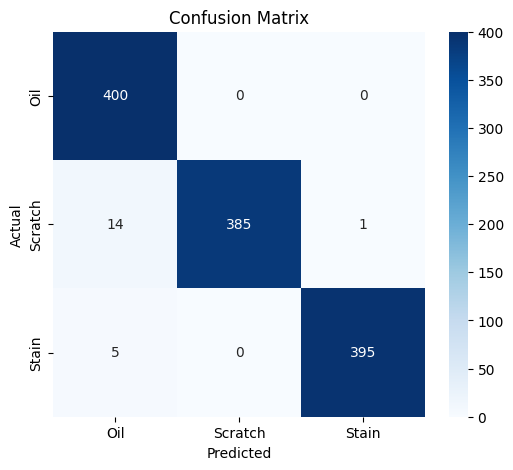

In [ ]:
# Print classification report
print(classification_report(y_true, y_pred))

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
classes = ["Oil", "Scratch", "Stain"]  # Update if needed

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()